In [64]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [65]:
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [66]:
len(words)

32033

In [67]:
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [108]:
block_size = 3

X, Y = [], []
for w in words:
    context = [0] * block_size
    for ch in w + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)


In [109]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [193]:
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

Xtr, Ytr = build_dataset(words[:n1])
Xva, Yva = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [21]:
C = torch.randn((27,2))

In [22]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [40]:
W1 = torch.rand((6, 100))
b1 = torch.rand(100)

In [41]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [42]:
h

tensor([[ 0.9449,  0.9824,  0.9009,  ...,  0.9820,  0.9434,  0.8145],
        [-0.8991, -0.2080, -0.9031,  ..., -0.0023, -0.7211, -0.9170],
        [-0.4561,  0.4320, -0.7194,  ..., -0.3491, -0.9450, -0.3685],
        ...,
        [ 0.9754,  0.9529,  0.9957,  ...,  0.9953,  0.9987,  0.9983],
        [ 0.9716,  0.9434, -0.3676,  ...,  0.9741,  0.9309,  0.8890],
        [ 0.9895,  0.9831,  0.9514,  ...,  0.9849,  0.9981,  0.9972]])

In [43]:
W2 = torch.rand((100, 27))
b2 = torch.rand(27)

In [48]:
logits = h @ W2 + b2

In [45]:
logits.shape

torch.Size([32, 27])

In [50]:
counts = logits.exp()

In [51]:
prob = counts / counts.sum(dim=1, keepdim=True)

In [52]:
prob.shape

torch.Size([32, 27])

In [55]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(4.9586)

In [53]:
torch.arange(32)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

# ------------------

In [194]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [235]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [236]:
sum(p.nelement() for p in parameters)

11897

In [237]:
for p in parameters:
    p.requires_grad = True

In [238]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [239]:
lri = []
lossi = []
stepi = []

In [248]:

for i in range(50000):
    # minibatch construction
    # ix = torch.randperm(len(X))[:32]
    ix = torch.randint(0, Xtr.shape[0], (32,), generator=g)

    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # print(loss.item())

    

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    # lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())


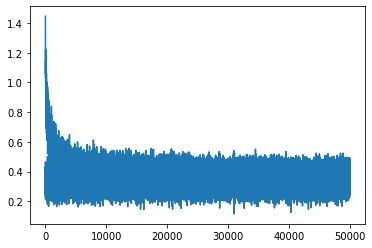

In [249]:
plt.plot(stepi, lossi)

In [250]:
# plt.plot(lri, lossi)
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1708, grad_fn=<NllLossBackward0>)

In [251]:
emb = C[Xva]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yva)
loss

tensor(2.2014, grad_fn=<NllLossBackward0>)

In [252]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print("".join(itos[i] for i in out))

carpailah.
jheri.
kemri.
rehty.
skandelena.
hubeda.
esric.
kaqui.
nellaiah.
maiir.
kaleigh.
ham.
por.
dessan.
shor.
emila.
biur.
jerma.
jarynix.
kaelisselios.
